In [17]:
import re
import regex
import spacy
import csv
import matplotlib.pyplot as plt
import string
from collections import Counter
from functools import reduce
from Levenshtein import distance
from elasticsearch import Elasticsearch

In [18]:
# 1. Use SpaCy tokenizer API to tokenize the text from the law corpus.
nlp = spacy.load("pl_core_news_sm")

In [19]:
# 2. Compute frequency list for each of the processed files.
def tokenize_files():
    files = os.listdir("ustawy")
    frequence_dict = {}
    for file_name in files:
        with open("ustawy" + '/' + file_name, 'r') as document:
            doc = nlp(document.read())
        #doc = nlp("a kto nie chcę tego robić zm.[21' kto nie 2razy pod nie 'v+/' rząd_ why& ^&^j")
        tokens = [token.lemma_ for token in doc]
        frequence_dict[file_name] = Counter(tokens)
    return frequence_dict 

In [20]:
# 3. Aggregate the result to obtain one global frequency list.
def create_global_frequence_list(frequence_dict):
    return reduce(lambda x, y: x + y, frequence_dict.values())

In [21]:
# 3. Reject all entries that are shorter than 2 characters or contain non-letter characters (make sure to include Polish diacritics).
def filter_frequency_list(global_frequence_list):
    return Counter(dict(filter(lambda x: len(x[0]) >= 2 and re.match(r'^[^\W\d_]*$', x[0]), global_frequence_list.most_common())))

In [22]:
# 4. Make a plot in a logarithmic scale:
def plot(filtered_frequency_list):
    plt.plot(filtered_frequency_list.values())
    plt.yscale("log")

In [23]:
# 5. Download polimorfologik.zip dictionary
def download_polimorfik():
    unique_forms = set()
    with open('polimorfologik-2.1/polimorfologik-2.1.txt') as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=';')
        polimorfologik_words = {row[1].lower() for row in csv_reader}
    return polimorfologik_words

In [24]:
# 5. use it to find all words that do not appear in that dictionary.
def missing_words_polimorfologik(filtered_frequency_list, polimorfologik_words):
    missing_words = [x for x in filtered_frequency_list.most_common() if x[0] not in polimorfologik_words]
    return missing_words

In [25]:
# 6. Find 30 words with the highest ranks that do not belong to the dictionary.
def find_highest_missing_words(missing_words):
    return missing_words[:30]

In [26]:
# 7. Find 30 words with 5 occurrences that do not belong to the dictionary.
def find_missing_words_five_occurrences(missing_words):
    return list(filter(lambda x: x[1] == 5, missing_words))[:30]

In [27]:
# 8. Use Levenshtein distance and the frequency list, to determine the most probable correction of the words from the second list. (You don't           have to apply the distance directly. Any method that is more efficient than scanning the dictionary will be appreciated.)
def one_letter_off_strings(word):
    dif_list = []
    for i in range(len(word)):
        dif_list.extend((word[:i] + l + word[i+1:] for l in string.ascii_lowercase + 'ąóęł' if l != word[i]))
        dif_list.append(word[:i] + word[i+1:])
        dif_list.extend((word[:i] + l + word[i:] for l in string.ascii_lowercase + 'ąóęł'))
    return dif_list


def levenshtein_dist(missing_words_five_occurrences, filtered_frequency_list):
    predictions = {}
    for missing_word in missing_words_five_occurrences:
        distance = 0
        missing_word_occurances = Counter()
        words_to_compare = {missing_word[0]}
        while not missing_word_occurances and distance < 3:
            distance += 1 
            for word_to_compare in list(words_to_compare):
                words_to_compare.remove(word_to_compare)
                dist_words = one_letter_off_strings(word_to_compare)
                for dist_word in dist_words:
                    words_to_compare.add(dist_word)
                    if dist_word in filtered_frequency_list.keys() and dist_word != missing_word[0]:
                        missing_word_occurances.update({dist_word:filtered_frequency_list[dist_word]})
        try:
            predictions[missing_word[0]] = missing_word_occurances.most_common()[0][0]
        except :
            predictions[missing_word[0]] = None
        print(predictions)
    return predictions

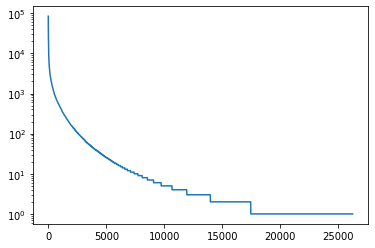

In [28]:
frequence_dict = tokenize_files()
global_frequence_list = create_global_frequence_list(frequence_dict)
filtered_frequency_list = filter_frequency_list(global_frequence_list)
plot(filtered_frequency_list)

In [29]:
polimorfologik_words = download_polimorfik()
missing_words = missing_words_polimorfologik(filtered_frequency_list, polimorfologik_words)
highest_missing_words = find_highest_missing_words(missing_words)
missing_words_five_occurrences = find_missing_words_five_occurrences(missing_words)
print(missing_words_five_occurrences)

[('pełnoporcjowej', 5), ('sposb', 5), ('próbobiorców', 5), ('Biała', 5), ('kj', 5), ('zalesianin', 5), ('sprawdzeń', 5), ('agave', 5), ('Moskwa', 5), ('naukowobadawczych', 5), ('eudravigilance', 5), ('naliczeń', 5), ('odwzorowań', 5), ('ekofizjograficznych', 5), ('regazyfikacyjnego', 5), ('xxii', 5), ('Grzywno', 5), ('szcze', 5), ('swine', 5), ('contagious', 5), ('Siedlec', 5), ('adopcyjnoopiekuńczych', 5), ('jed', 5), ('underline', 5), ('wapnio', 5), ('izobutyl', 5), ('cznika', 5), ('zawart', 5), ('ośc', 5), ('ami', 5)]


In [ ]:
predictions = levenshtein_dist(missing_words_five_occurrences, filtered_frequency_list)
print(predictions)

In [30]:
# Load Morfologik to ElasticSearch (one document for each form)
def create_index(elastic_client):
    elastic_client.indices.create(
        index="morfologik_index",
        body={
            "settings":{  
                "analysis":{  
                    "analyzer": "standard"
                }
            },
    "mappings":{
            "properties":{
                "word": {"type":"text",}
            }
        }
    }
    )


def add_words(elastic_client):
    with open('polimorfologik-2.1/polimorfologik-2.1.txt') as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=';')
        counter = 0
        for row in csv_reader:
            elastic_client.create("morfologik_index", counter, {"word": row[1]})
            counter += 1

In [31]:
# Use fuzzy matching to obtain the possible corrections of the 30 words with 5 occurrences that do not belong to the dictionary.
def find_predictions(elastic_client, missing_words_five_occurrences):
    predictions = {}
    for missing_word in missing_words_five_occurrences:
        query_body = {"query": {
                        "fuzzy": {
                            "word": missing_word[0]
                                }
                            }
                    }
        result = elastic_client.search(index="morfologik_index", body=query_body)
        try:
            predictions[missing_word[0]] = result["hits"]["hits"][0]['_source']['word']
        except IndexError:
            pass
    return predictions


In [32]:
elastic_client = Elasticsearch()
elastic_client.indices.delete(index='morfologik_index', ignore=[400, 404])
create_index(elastic_client)
add_words(elastic_client)

KeyboardInterrupt: 

In [ ]:
predictions_elastic = find_predictions(elastic_client, missing_words_five_occurrences)
print(predictions_elastic)